In [ ]:
!pip uninstall -qy jupyterlab jupyterlab-lsp
!pip install -qU 'google-genai==1.7.0'
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.8 MB/s eta 0:00:00


'1.7.0'

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [5]:
#without search grounding
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

As of today, October 26, 2023, Billie Eilish doesn't have any upcoming concerts scheduled.

Her most recent tour, the "Happier Than Ever, The World Tour," concluded in September 2022.

To stay up-to-date on future tour announcements, you can:

*   **Follow her official website:** Check her official website regularly for any announcements: www.billieeilish.com
*   **Follow her social media:** Follow her on platforms like Instagram, Twitter, and Facebook.
*   **Sign up for her mailing list:** Often, artists announce tours to their mailing list subscribers first.


In [6]:
#with search grounding - more metadata,links to search suggestions,supporting documents and info
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="When and where is Billie Eilish's next concert?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Billie Eilish's next concert is on **April 23, 2025,** at the **Avicii Arena in Stockholm, Sweden.** After that, she will perform at the same venue on April 24.


In [7]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

songkick.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAL67SPOUbF6wscfwxRfTMpXNXJrxhA9sQFJ1WDDaAy0s9MZF3CQTFutMPzekx_zNcOy6-QpqnikiMBYJNm0kj8_ZLX4faJ6dIpWRpbhDTud6EysRTUnzLIJtBIdp7eSslJ3LXZQUdTOgA6b6irbvucn2qU38MAz4tC7KA==
billieeilishtours2025.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJiJAln9IEdHtLCGrDwBWSd89GuDob9a_cxQTbdhjJjmH0Gj1DPtEXuE-zZQinMqF9Ykqd3NpMkZVDoHmNnK6NLEY7VCc-I3pJFf0zkTe4uSJdnEueds5__GHdqlyIB-hFm
ticketmaster.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALbpmFIUIj25ayRFyFLabw3XAXiKZ2pO6R44iuccTiUSHCK7RfEuzxhG1y9kOsqeQqL-7KcaoKVTjmKc5CaGz-0hjX1BBTGxgCqAMB8CRJwy-PgidMW-ho0vDu3i25qRLnnGrM7YZiHdTq6pwqZQJ-lWVGJv19nTZZbJugO


In [8]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

In [9]:
from pprint import pprint

supports =rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.61371523, 0.65534914, 0.6755326],
 'grounding_chunk_indices': [0, 1, 2],
 'segment': {'end_index': 160,
             'text': "Billie Eilish's next concert is on **April 23, 2025,** "
                     'at the **Avicii Arena in Stockholm, Sweden.** After '
                     'that, she will perform at the same venue on April 24.'}}


In [11]:
import io

markdown_buffer = io.StringIO()

markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")

markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")

Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish's next concert is on **April 23, 2025,** at the **Avicii Arena in Stockholm, Sweden.** After that, she will perform at the same venue on April 24.<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup>

Citations:

1. [songkick.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAL67SPOUbF6wscfwxRfTMpXNXJrxhA9sQFJ1WDDaAy0s9MZF3CQTFutMPzekx_zNcOy6-QpqnikiMBYJNm0kj8_ZLX4faJ6dIpWRpbhDTud6EysRTUnzLIJtBIdp7eSslJ3LXZQUdTOgA6b6irbvucn2qU38MAz4tC7KA==)
2. [billieeilishtours2025.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJiJAln9IEdHtLCGrDwBWSd89GuDob9a_cxQTbdhjJjmH0Gj1DPtEXuE-zZQinMqF9Ykqd3NpMkZVDoHmNnK6NLEY7VCc-I3pJFf0zkTe4uSJdnEueds5__GHdqlyIB-hFm)
3. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALbpmFIUIj25ayRFyFLabw3XAXiKZ2pO6R44iuccTiUSHCK7RfEuzxhG1y9kOsqeQqL-7KcaoKVTjmKc5CaGz-0hjX1BBTGxgCqAMB8CRJwy-PgidMW-ho0vDu3i25qRLnnGrM7YZiHdTq6pwqZQJ-lWVGJv19nTZZbJugO)


In [13]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [14]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here is the medal tally for the top 10 countries at the 2024 Paris Olympics:

1.  **United States of America:** 40 Gold, 44 Silver, 42 Bronze (126 total)
2.  **People's Republic of China:** 40 Gold, 27 Silver, 24 Bronze (91 total)
3.  **Japan:** 20 Gold, 12 Silver, 13 Bronze (45 total)
4.  **Australia:** 18 Gold, 19 Silver, 16 Bronze (53 total)
5.  **France:** 16 Gold, 26 Silver, 22 Bronze (64 total)
6.  **Netherlands:** 15 Gold, 7 Silver, 12 Bronze (34 total)
7.  **Great Britain:** 14 Gold, 22 Silver, 29 Bronze (65 total)
8.  **Republic of Korea:** 13 Gold, 9 Silver, 10 Bronze (32 total)
9.  **Italy:** 12 Gold, 13 Silver, 15 Bronze (40 total)
10. **Germany:** 12 Gold, 13 Silver, 8 Bronze (33 total)

----

I apologize for the previous error. I misunderstood your request and provided a stacked bar chart instead of separate bars for each medal type. Let's correct that and create a grouped bar chart using Seaborn.



----

{'executable_code': {'code': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Data from the previous response\ndata = {\n    'Country': ['United States of America', 'People\\'s Republic of China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],\n    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\ndf = pd.DataFrame(data)\n\n# Melt the dataframe to long format\ndf_melted = df.melt(id_vars='Country', var_name='Medal', value_name='Count')\n\n# Plotting the chart\nplt.figure(figsize=(14, 8))  # Adjust figure size for better readability\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette=['gold', 'silver', 'brown'])  # Use appropriate colors\n\nplt.title('2024 Olympics Medal Tally (Top 10 Countries)')\nplt.xlabel('Country')\nplt.ylabel('Number of Medals')\nplt.xtic

----

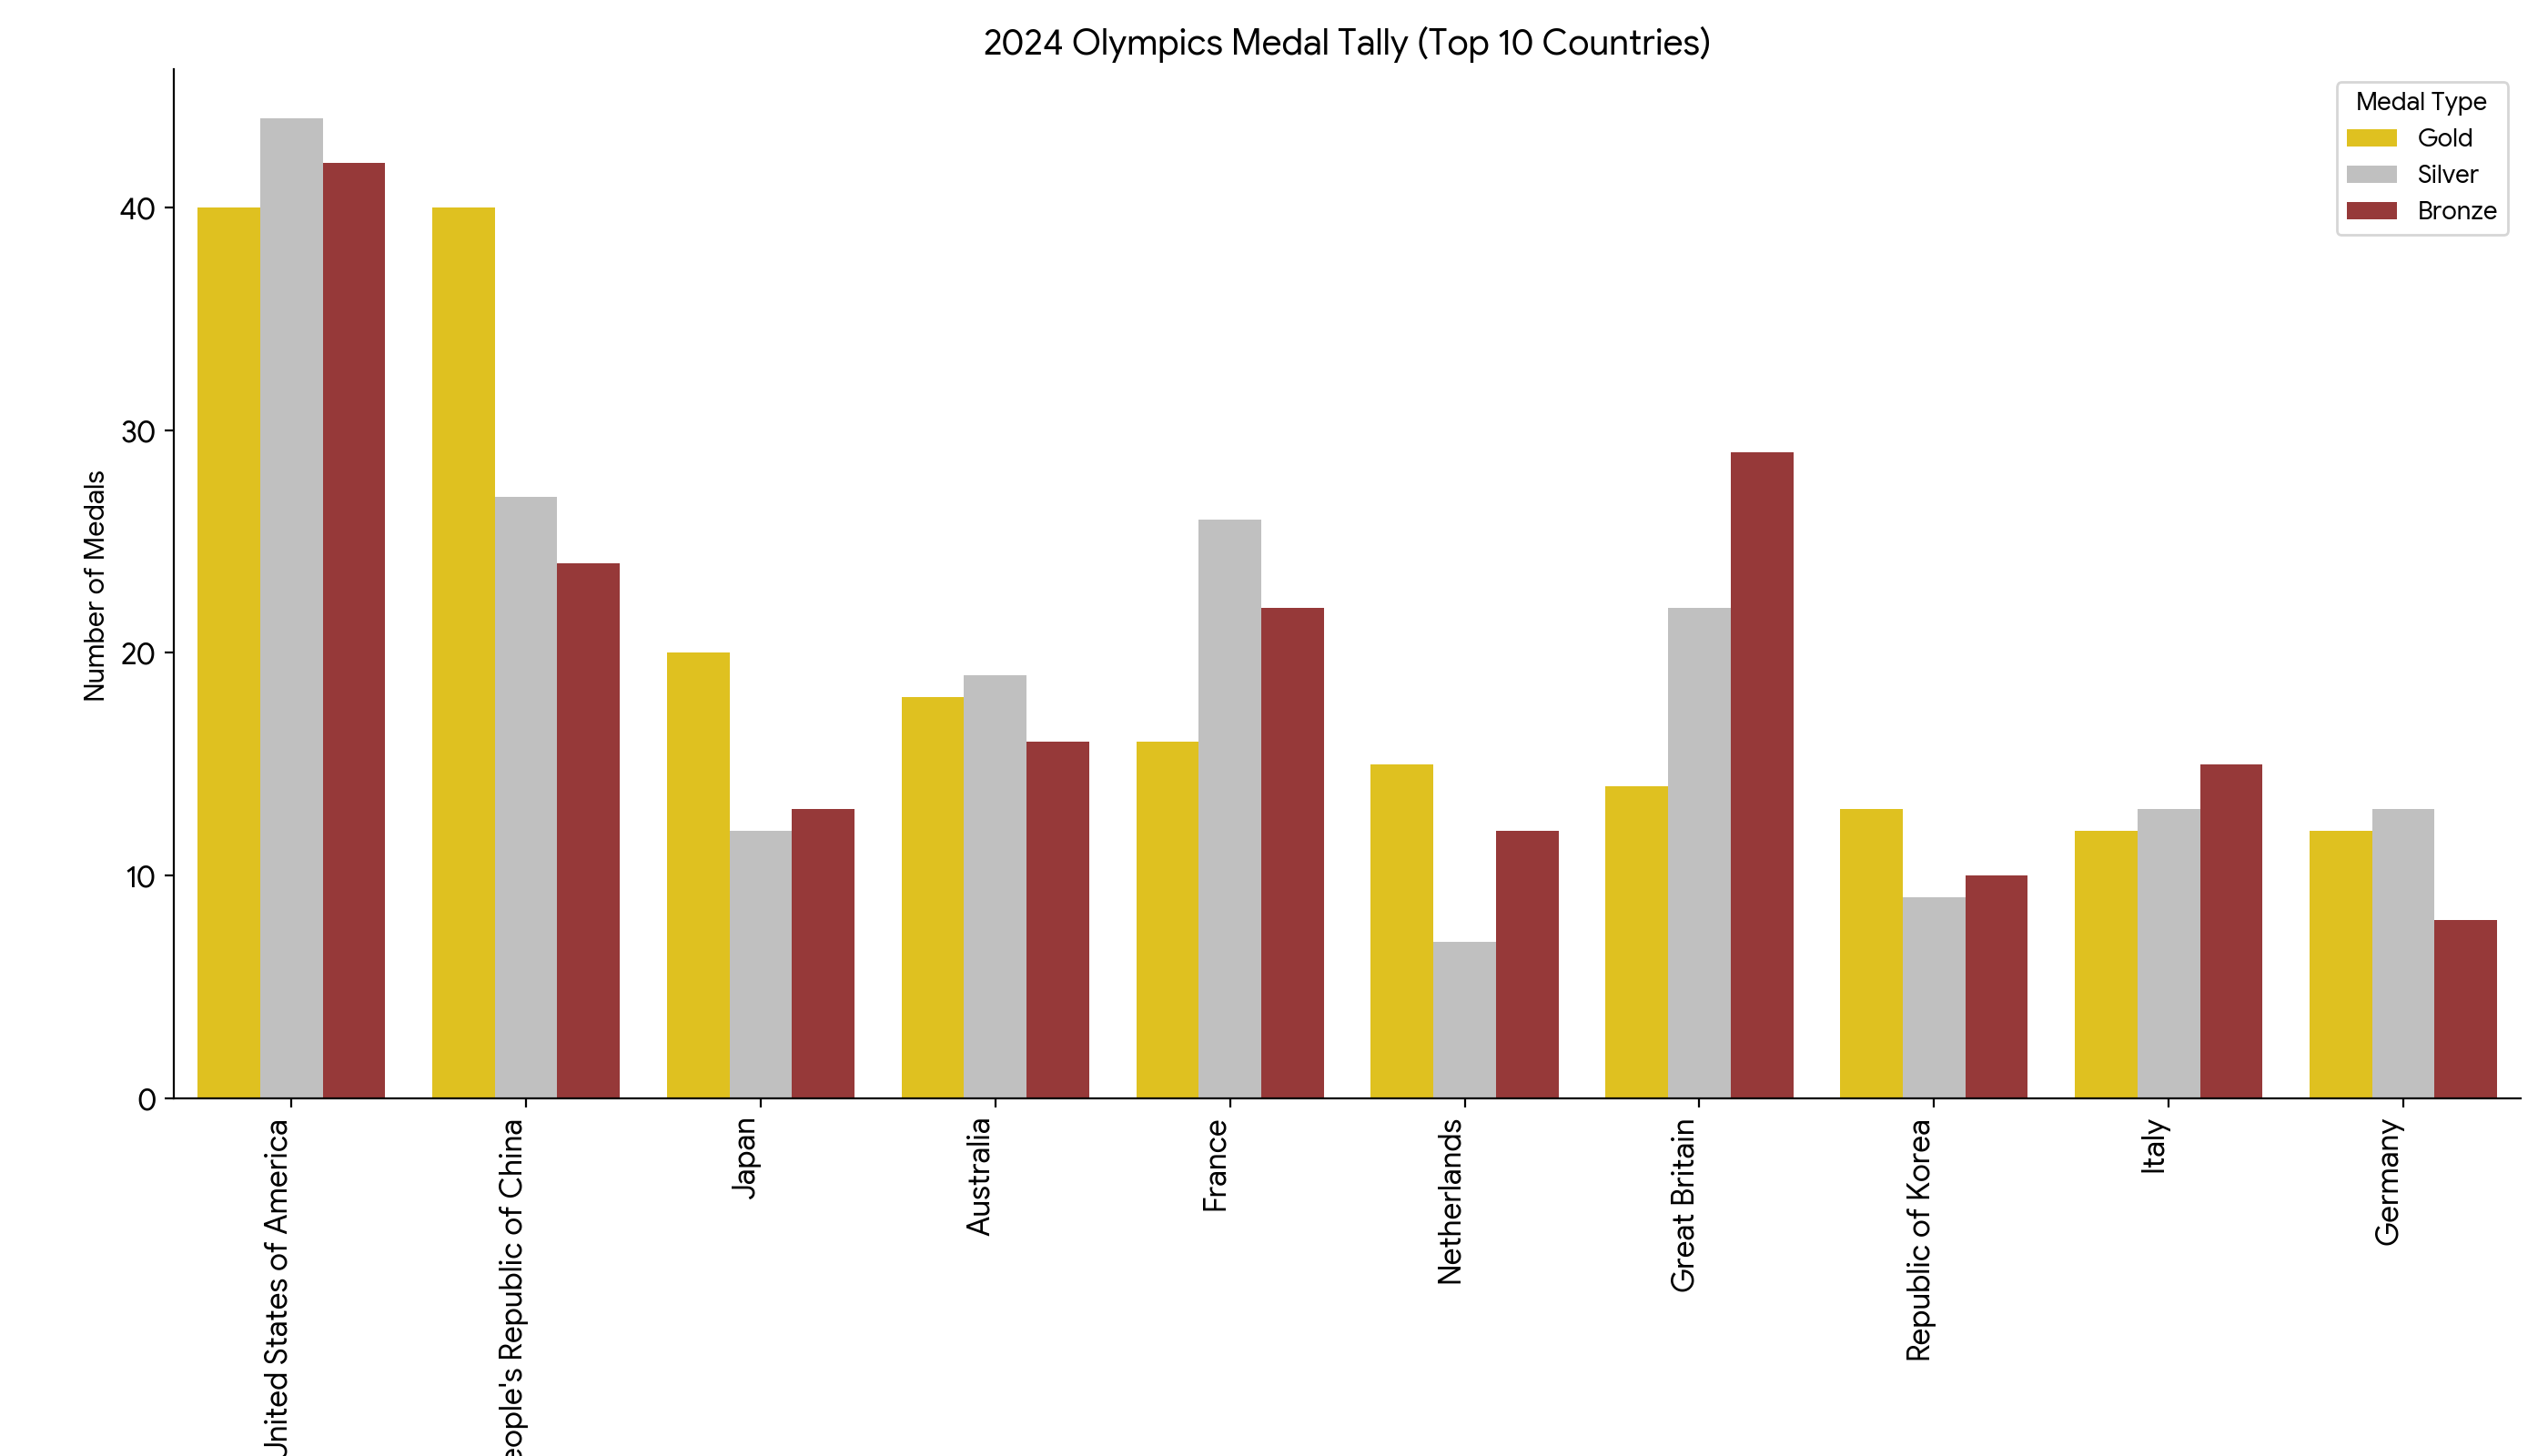

----

The image shows a grouped bar chart of the 2024 Olympics Medal Tally for the top 10 countries. The x-axis represents the countries, and the y-axis represents the number of medals. Each country has three bars representing the number of Gold, Silver, and Bronze medals, respectively. The colors used are gold, silver, and brown. The x-axis labels are rotated for readability. The title of the chart is "2024 Olympics Medal Tally (Top 10 Countries)". The legend indicates the medal type.


----

In [16]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)
response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals with gold,silver and bronze.",
    config=config_with_code,
)
show_response(response)